Importamos las bibliotecas necesarias para trabajar con datos, algoritmos de Machine Learning y visualización.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Configuramos una semilla aleatoria para reproducibilidad.

In [2]:
np.random.seed(123)

Cargamos el dataset que contiene indicadores de salud y diagnósticos de diabetes.

In [3]:
data = pd.read_csv('../data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

# Identificar tipos de columnas
binary_columns = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                  'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
                  'NoDocbcCost', 'DiffWalk', 'Sex']
categorical_columns = ['GenHlth', 'Age', 'Education', 'Income']
continuous_columns = ['BMI', 'MentHlth', 'PhysHlth']


# Si las columnas categóricas no tuviesen orden, sería una buena praxis definir un pipeline.
# OrdinalEncoder captura el orden lógico de las categoría, mientras que MinMaxScaler normaliza las categorías al rango [0, 1] para evitar sesgos.
# Para este caso particular, como hemos nombrado, no es necesario, pero es algo a tener en cuenta para otro tipo de dataset.
categorical_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder()),
    ('scaler', MinMaxScaler())     
])

# Preprocesamos los datos transformando las columnas según aplique
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', 'passthrough', binary_columns),
        ('categorical', 'passthrough', categorical_columns),
        ('continuous', StandardScaler(), continuous_columns)
    ]
)

# Aplicamos el preprocesamiento
X = preprocessor.fit_transform(X)

column_names = preprocessor.get_feature_names_out()

Evaluamos el dataset. En primer lugar normalizamos los datos y aplicamos validación cruzada.

In [4]:
def evalua(X, y, regresor=LinearRegression()):
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    scores = cross_val_score(regresor, X_scaled, y, cv=5)
    return scores.mean()

Aplicamos el selector RFE sobre X usando como estimador base LinearRegression, y mostramos el ranking de atributos resultante

In [5]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
selector_RFE = RFE(LinearRegression(), n_features_to_select=1)
selector_RFE.fit(X_scaled,y)
ranking_X = selector_RFE.ranking_

ranking_X

array([ 2,  5,  7, 20, 15, 10, 17, 19, 16,  6, 18, 21, 12,  9,  1,  4, 13,
        8,  3, 14, 11])

Construimos una lista ordenada de los nombres de atributos a partir de un ranking y su correspondiente matriz X.

In [6]:
def ranking_nombres_atributos(ranking, nombres_atributos):
    posiciones_atributos = list(zip(ranking, list(nombres_atributos)))
    posiciones_atributos.sort()
    print("Posiciones atributos", posiciones_atributos)
    return([a for _,a in posiciones_atributos])

column_names = [col.replace("binary__", "").replace("categorical__", "").replace("continuous__", "") 
                        for col in column_names]
atributos = ranking_nombres_atributos(ranking_X, column_names)

Posiciones atributos [(1, 'GenHlth'), (2, 'HighBP'), (3, 'BMI'), (4, 'Age'), (5, 'HighChol'), (6, 'HvyAlcoholConsump'), (7, 'CholCheck'), (8, 'Income'), (9, 'Sex'), (10, 'HeartDiseaseorAttack'), (11, 'PhysHlth'), (12, 'DiffWalk'), (13, 'Education'), (14, 'MentHlth'), (15, 'Stroke'), (16, 'Veggies'), (17, 'PhysActivity'), (18, 'AnyHealthcare'), (19, 'Fruits'), (20, 'Smoker'), (21, 'NoDocbcCost')]


De esta manera, observamos que los atributos de mayor relevancia son:
1. GenHlth: Indica si el paciente tiene una buena salud en general
2. HighBP: Indica si el paciente tiene la presión arterial alta
3. BMI: Indica el índice de masa corporal
4. Age: Indica la categoría de edad del paciente
5. HighChol: Indica si el paciente tiene colesterol alto

...

A partir de este punto, comprobamos el efecto de eliminar uno a uno los peores atributos de una matriz X, y se evalua el dataset que va quedando

In [7]:
def evolucion_quitando_peor_atributo(X, y, selector_rfe):
    '''     
    Entrada:
       - X: dataframe con los atributos
       - y: serie con la clase
       - selector_rfe: selector RFE usado
    Salida:
       - Gráfica con la evolución
       - Mejor resultado obtenido
    '''
    selector_rfe.fit(X,y)
    ranking = selector_rfe.ranking_
    resultados = []
    atributos_seleccionados = ranking_nombres_atributos(ranking, X.columns)
    for i in range(len(ranking)):
        X_sel = X[atributos_seleccionados]
        resultado = evalua(X_sel, y)
        resultados.append(resultado)
        atributos_seleccionados = atributos_seleccionados[:-1]
    plt.plot(resultados)
    plt.show()
    return(max(resultados))

Finalmente, calculamos el resultado sobre X sin selección, y a su vez, el mejor resultado obtenido sobre X en la secuencia de experimentos RFE.

Posiciones atributos [(1, 14), (2, 0), (3, 18), (4, 15), (5, 1), (6, 9), (7, 2), (8, 17), (9, 13), (10, 5), (11, 20), (12, 12), (13, 16), (14, 19), (15, 4), (16, 8), (17, 6), (18, 10), (19, 7), (20, 3), (21, 11)]


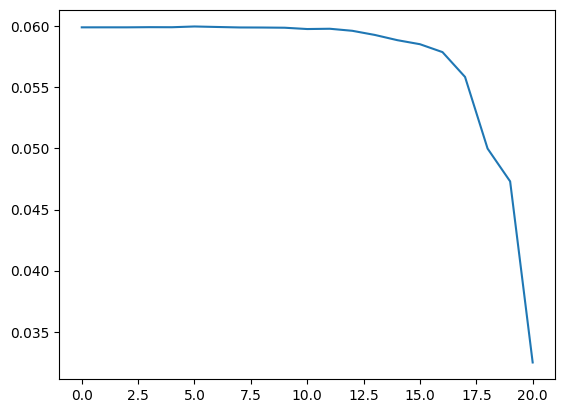

,X,Mejora para X
RFE - LR,0.059976,0.000071


In [8]:
scaler1 = preprocessing.StandardScaler().fit(X)
X = pd.DataFrame(scaler1.transform(X))

resultado_X = evalua(X, y)
resultado_X_seleccion = evolucion_quitando_peor_atributo(X, y, RFE(LinearRegression(), n_features_to_select=1))

RESULTADOS = pd.DataFrame(columns=['X', 'Mejora para X'])
RESULTADOS.loc['RFE - LR'] = (resultado_X_seleccion, resultado_X_seleccion-resultado_X)
RESULTADOS

Si analizamos el gráfico, podemos observar que a partir del atributo 32 la función decrece significativamente. De esta manera, todos los atributos situados más a la derecha en el ranking empeoran el modelo. Vamos a comprobar cuáles son, y si resulta haber diferencia respecto al modelo de selección 1, donde inicialmente no se han realizado técnicas de transformación de las columnas.

In [9]:
print(sorted(atributos[12:]))

['AnyHealthcare', 'Education', 'Fruits', 'MentHlth', 'NoDocbcCost', 'PhysActivity', 'Smoker', 'Stroke', 'Veggies']


Evaluamos los resultados obtenidos en cada proceso de selección para determinar si es beneficioso transformar las columnas.

Conjunto de atributos a eliminar según el notebook Seleccion.ipynb:

- Solución: ['AnyHealthcare', 'Education', 'Fruits', 'MentHlth', 'NoDocbcCost', 'PhysActivity', 'Smoker', 'Stroke', 'Veggies']

Conjunto de atributos a eliminar según el notebook Seleccion-transformada.ipynb:

- Solución: ['AnyHealthcare', 'Education', 'Fruits', 'MentHlth', 'NoDocbcCost', 'PhysActivity', 'Smoker', 'Stroke', 'Veggies']

En conclusión, transformar las columnas no produce cambios en las redundancia de los atributos. Como siguiente paso, vamos a comprobar en los ficheros knn_minkowski_sin_seleccion.ipynb y knn_minkowski_seleccion.ipynb si eliminar los atributos irrelevantes conlleva un menor ruido en el cálculo de distancias, y por ende, un mejor resultado.
